In [1]:
!pip3 install pypolyagamma

     |████████████████████████████████| 235kB 2.8MB/s 
  Created wheel for pypolyagamma: filename=pypolyagamma-1.2.2-cp36-cp36m-linux_x86_64.whl size=577274 sha256=9c960d4a27e88a13befe5aa4ee2f90e14351045c937cb7980b6f6c41511cd547
  Stored in directory: /root/.cache/pip/wheels/ff/b4/34/046d7d99529aa5fe3ab7755a0a37885e6c0d1bdc601c146bf0
Successfully built pypolyagamma


In [0]:
from pypolyagamma import PyPolyaGamma

In [4]:
!git clone https://github.com/slinderman/ssm.git
%cd ssm
!pip install -e .

Cloning into 'ssm'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 2603 (delta 238), reused 256 (delta 165), pack-reused 2268
Receiving objects: 100% (2603/2603), 19.62 MiB | 38.20 MiB/s, done.
Resolving deltas: 100% (1823/1823), done.
/content/ssm
Obtaining file:///content/ssm
  Running setup.py develop for ssm


In [0]:
from ssm import messages

In [0]:
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import sys

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [0]:
# Define the piecewise linear tanh approximation
class PiecewiseLinearSigmoid(object):
    """
    Piecewise linear approximation to sigma(x) with the specified 
    window size and number of linear parts.
    """
    def __init__(self, num_parts=16, window=4):
        self.num_parts = num_parts
        print('num_parts={}'.format(num_parts))
        self.knots = np.linspace(-window, window, num_parts-1)
        self.values = sigmoid(self.knots)

        # Compute slopes and intercepts for each bin
        self.slopes = np.concatenate(([0], np.diff(self.values) / np.diff(self.knots), [0]))
        self.intercepts = np.concatenate(([self.values[0]], self.values - self.slopes[1:] * self.knots))

    def f(self, x):
        z = np.digitize(x, self.knots)
        return self.intercepts[z] + self.slopes[z] * x
        
class PiecewiseLinearTanh(PiecewiseLinearSigmoid):
    def f(self, x):
        return 2 * super(PiecewiseLinearTanh, self).f(2 * x) - 1



In [0]:
# Define the piecewise linear sigmoid approximation
class StochPiecewiseLinearSigmoid(PiecewiseLinearSigmoid):
    """
    Stochastic p.w.l. approximation to sigma(x) with the specified 
    window size and number of linear parts.  Here, the discrete
    part is chosen randomly based on a tree-structured stick breaking
    of the interval.
    """
    def __init__(self,W,B,sigmasq=None,num_parts=16, window=4, temp=0.25):
        super(StochPiecewiseLinearSigmoid, self).__init__(num_parts, window)
        self.temp = temp
        self.W = W
        self.B = B 
        self.z=None
        self.output = None
        self.sigmasq_out = sigmasq
        self.ms=None
        self.Vs=None


        # Precompute the transition probabilities on a dense grid        
        # num_pts = 1000
        # x = np.linspace(-1.5 * window, 1.5 * window, num_pts)
        # p = np.ones((num_pts, num_parts))

        # Get length of binary representation (i.e. depth of tree)
        decimal, depth = np.modf(np.log2(num_parts))
        assert np.allclose(decimal, 0), "number of parts must be a power of 2."
        depth = int(depth)
        self.depth = depth

        # Get a binary representation of each of the discrete parts
        self._bs = np.unpackbits(
            np.arange(self.num_parts, 
                      dtype=np.uint8)[:, None], axis=1)[:, -(self.depth):]

        # Precompute indices of decision knots for each discrete state
        mids = 2**np.arange(self.depth - 1, -1, -1)
        lefts = np.column_stack((np.zeros(self.num_parts), 
                                 np.cumsum(self._bs[:, :-1] * mids[:-1], axis=1)))
        self._inds = np.array(lefts + mids - 1, dtype=int)

    def get_inx(self, x, u):
      return self.W @ x  + self.B @ u
    
    def get_Wbar(self):
      Wbar = np.concatenate((self.W, self.B), axis=1)
      return Wbar

    def split_Wbar(self, Wbar):
      d = self.W.shape[0]
      ud = self.B.shape[1]
      self.W = Wbar[:,:d]
      self.B = Wbar[:,d:]

    def get_r(self,x,u):
      r = np.concatenate((x, u), axis=2)
      rrT = (r[:,...,None]*r[:,:,None,:])[:,:,:,:,0]
      return r, rrT  
    
    def f_given_z(self, x, z):
      return self.intercepts[z] + self.slopes[z] * x
    
    def f(self, x, return_z=False):
        """
        Sample a discrete state given x, then return the corresponding
        linear function of x.
        """
        x = np.atleast_1d(x)
        z = np.zeros_like(x, dtype=int)
        shp = x.shape
        for d in range(self.depth):
            mid = 2**(self.depth-d-1) - 1
            choice = npr.rand(*shp) < sigmoid((x - self.knots[z + mid]) / self.temp)
            z += choice * (mid + 1)
                
        if return_z:
            return StochPiecewiseLinearSigmoid.f_given_z(self,x,z), z
        else:
            return StochPiecewiseLinearSigmoid.f_given_z(self,x,z)

        
    def discrete_prior(self, x):
        """
        Get the prior on discrete states for input x
        """
        num_obs=x.shape[0]
        N = x.shape[1]
        d = x.shape[2]
        # To compute the posterior distribution of discrete states,
        # first evaluate sigmoids at each (input, knot) pair.
        s = sigmoid((x - self.knots[None,None, :]) / self.temp)
        oms = 1 - s
        # Discrete state probabilities are products of sigmoids for subsets
        # of knots.
        prior = np.ones((num_obs,N, d, self.num_parts))
        for k in range(self.num_parts):
            bk = self._bs[k]
            ik = self._inds[k]
            prior[:,:,:, k] = np.prod(s[:,:,:, ik[bk==1]], axis=3) * \
                          np.prod(oms[:,:,:, ik[bk==0]], axis=3)
        return prior


    def vectorized_sample_categorical(self, prob_matrix, items):
        prob_matrix=prob_matrix.T
        s = prob_matrix.cumsum(axis=0)
        r = np.random.rand(prob_matrix.shape[1])
        k = (s < r).sum(axis=0)
        return items[k]


    def resample_discrete_states(self, x, log_lkhd):
        """
        Sample discrete variable z given (input, output) pair (x, y) and 
        Gaussian noise variance sigmasq.
        """
        # Get the log prior on discrete states
        log_prior = np.log(self.discrete_prior(x))

        # Posterior is proportional to prior * lkhd
        log_post = log_prior + log_lkhd
        post = np.exp(log_post - logsumexp(log_post, axis=3, keepdims=True))
        self.cond_z = post 

        # Sample the posterior
        post = post.reshape(x.shape[0]*x.shape[1]*x.shape[2] ,self.num_parts)
        z = self.vectorized_sample_categorical(post, np.arange(self.num_parts))
        z = z.reshape(x.shape[0],x.shape[1], x.shape[2],1)
        return z

    def resample_auxiliary_variables(self, x, z):
        # Sample the conditional distribution of the Polya-gamma auxiliary 
        # variable \omega given the input x.  Here the discrete state really
        # corresponds to a set of Bernoulli random variables.  Each one is 
        # parameterized as,
        #
        #     b_i ~ Bern(\sigma((x - \theta_i) / tau)) 
        # 
        # where \theta_i is the knot for the i-th choice.  The conditional
        # distribution is \omega ~ PG(1, (x - \theta_i) / tau)), and is 
        # independent of the binary outcome b_i. 
        z = z.ravel()
        b = self._bs[z]
        i = self._inds[z]     
        u = (x.ravel()[:, None] - self.knots[i]) / self.temp
        # Sample the auxiliary variable and compute the potential on u
        pg_shp = u.ravel().shape
        pg = PyPolyaGamma(seed=npr.randint(0,100000000))
        Ju = np.empty(pg_shp)        
        pg.pgdrawv(np.ones(pg_shp), u.ravel(), Ju)
        Ju = Ju.reshape(u.shape)
        hu = b - 0.5
        # Convert to mean parameters
        mu = hu / Ju
        Vu = 1 / Ju
        # Convert the potential on u to a potential on x.
        mx = mu * self.temp + self.knots[i]
        Vx = Vu * self.temp**2
        # Convert back to natural parameters, sum, and return mean
        Jx = np.sum(1 / Vx, axis=1)
        hx = np.sum(mx / Vx, axis = 1)
        mx = hx / Jx
        Vx = 1 / Jx
        return mx.reshape(x.shape), Vx.reshape(x.shape)

    def resample(self, x, log_lkhd):
        """
        Resample the discrete state and auxiliary variables for given inputs (x) 
        and outputs (y), and given noise variance sigmasq. 
        """
        # First sample the discrete states
        zs = self.resample_discrete_states(x, log_lkhd)
        #bs = self._bs[zs]

        # Then sample auxiliary variables from conditional and compute the 
        # effective Gaussian observation potential.
        mx, Vx = self.resample_auxiliary_variables(x, zs)
        return zs, mx, Vx

    def x_suff_stats(self,r, rrT, x, d):
        Er = r
        ErrT = rrT
        Erxd = np.zeros(((d,)+r.shape))
        for j in range(0,d):
          Erxd[j] = x[:,:,j,None]*r
        return Er, Erxd, ErrT

    def disc_aux_suff_stats(self,Vs,ms,zs):
        Eomega = 1/Vs
        Ekappa = Eomega*ms
      
        Eslopes_sq = (self.slopes[zs])**2
        Eslopes = self.slopes[zs]
        Eslopesints = self.slopes[zs]*self.intercepts[zs]
        return Eomega, Ekappa, Eslopes_sq, Eslopes, Eslopesints 

In [0]:
class StochPiecewiseLinearTanh(StochPiecewiseLinearSigmoid):
    def f(self, x, return_z=False):
        if return_z:
            y, z = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1, z
        else:
            y = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1


    def f_given_z(self, x, z):
      return 2*super(StochPiecewiseLinearTanh, self).f_given_z(2*x,z)-1
    
    def resample(self, x, log_lkhd):
        """
        Resample the discrete states and auxiliary variables given observations
        of y = tanh(x) + N(0, sigmasq).  This is equivalent to,

            y' = sigmoid(x') + N(0, sigmasq')

        where y' = (y + 1) / 2
              x' = 2 * x
              sigmasq' = sigmasq / 4

        The output is a set of discrete state samples and Gaussian potentials
        on the input to the sigmoid, here p(z | x) ~ N(x' | mx', Vx'), which is
        equivalent to N(x | mx'/2, Vx'/4) 
        """
        zs, mx, Vx = super(StochPiecewiseLinearTanh, self).\
            resample(2 * x, log_lkhd)

        return zs, mx / 2, Vx / 4
    

    def Wbar_params(self, Er, Erxd, ErrT, Eomega, Ekappa, Eslopes_sq, 
                    Eslopes, Eslopesints,sigmasq):
        
        d = self.W.shape[0]
        ud = self.B.shape[1]
        
        J = np.zeros((Er.shape[0], Er.shape[1],d,d+ud,d+ud))
        h = np.zeros((Er.shape[0], Er.shape[1],d,d+ud,1))
        for j in range(0,d):
          J[:,:,j] = Eomega[:,:,j,None]*ErrT #pg term
          J[:,:,j] += Eslopes_sq[:,:,j,None]*1/sigmasq[j,0]*ErrT #recurrence term
          
          h[:,:,j] = Ekappa[:,:,j,None]*Er  #pg term
          h[:,:,j] += 1/sigmasq[j,0]*Eslopes[:,:,j,None]*Erxd[j] #recurrence terms
          h[:,:,j] += -1/sigmasq[j,0]*Eslopesints[:,:,j,None]*Er #recurrence terms
          h[:,:,j] += 1/sigmasq[j,0]*Eslopes[:,:,j,None]*Er

        J = np.sum(J, axis=(0,1))
        h = np.sum(h, axis=(0,1))
        return J,h    

    def disc_aux_suff_stats(self,Vs,ms,zs):
      Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints=super(StochPiecewiseLinearTanh,
                                                        self).disc_aux_suff_stats(Vs,ms,zs)
      return Eomega, Ekappa, 16*Eslopes_sq, 4*Eslopes, 8*Eslopesints 
    
    # def gewecke_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma,Wbary_prior, Wbary_sigma, train_weights):
    #   self.gibbs_step(state, sigma, sigma_y, Wbar_prior, Wbar_sigma, Wbary_prior, Wbary_sigma,train_weights)
    #   #Samples ys for Gewecke testing
    #   state.y = state.C @ state.x[1:]+state.by+sigma_y*npr.randn(*state.y.shape)

In [0]:
class LinearObsModel(object):
  """Defines a Linear Gaussian Observation model"""
  def __init__(self, C, by, sigmasq):
    self.C = C
    self.by = by
    self.sigmasq = sigmasq

  def get_Wybar(self):
    Wybar = np.concatenate((self.C, self.by), axis=1)
    return Wybar

  def split_Wybar(self, Wybar):
    d = self.C.shape[1]
    self.C = Wybar[:,:d]
    self.by = Wybar[:,d:]

  def get_ry(self,x,num,T):
    r = np.concatenate((x[:,1:], np.ones((num,T,1,1))), axis=2)
    rrT = (r[:,...,None]*r[:,:,None,:])[:,:,:,:,0]
    return r, rrT   

  def suff_stats(self, ry, ryryT):
    return ry, ryryT

  def Wbar_params(self, y, Ery, EryryT):
    yd = self.C.shape[0]
    d = self.C.shape[1]
    J = np.zeros((yd, d+1,d+1))
    h = np.zeros((yd,d+1,1))
    Esum_rrT = np.sum(EryryT, axis=(0,1))

    for j in range(0,yd):
      J[j] = 1/self.sigmasq[j,0]*Esum_rrT 
      ydr = y[:,:,j,:].reshape(y.shape[0],y.shape[1],1,1)*Ery
      h[j] = 1/self.sigmasq[j,0]*np.sum(ydr, axis=(0,1))
    return J, h

  def x_params(self, y):
    J_obs = self.C.T@(1/self.sigmasq*self.C) 
    d = J_obs.shape[0]     
    J_obs = J_obs*np.ones((y.shape[0],y.shape[1]+1,d, d))
    J_obs[:,0] = np.zeros((y.shape[0],d,d))
    h_obs = ((1/self.sigmasq*self.C).T @ (y-self.by))[:,:,:,0]
    h_obs = np.concatenate((np.zeros((h_obs.shape[0],1,h_obs.shape[2])), h_obs),axis=1)
    return J_obs, h_obs

In [0]:
def cont_log_prior(x, mu, sigma):
  scale = sigma * np.ones(mu.shape)    
  return norm.logpdf(x, mu, scale)

def z_log_prior(z, obj, inx):
  zr = z.reshape(-1, 1).ravel()
  priorz = obj.discrete_prior(inx)
  priorz = priorz.reshape(-1,priorz.shape[3])      
  priorz = priorz[np.arange(len(zr)),zr]
  return np.sum(np.log(priorz))


def cond_z(gate):
  zr = gate.z.reshape(-1, 1).ravel()
  condz = gate.cond_z.reshape(-1,gate.cond_z.shape[3])
  return np.sum(np.log(condz[np.arange(len(zr)),zr]))

In [0]:
class StochPiecewiseLinearVanillaRNN(object):
    def __init__(self,W, B,mu_init,sigma_init,sigma_x, C, by, sigma_y, tanh_num_parts=16,
                 tanh_window=4, tanh_temp=0.25):
      self.spwl_tanh=StochPiecewiseLinearTanh(W,B,num_parts=tanh_numparts, 
                                              window=tanh_window,temp=tanh_temp)
      self.obs = LinearObsModel(C, by,sigma_y**2)
      self.mu_init=mu_init
      self.sigmasq_init=sigma_init**2 
      self.sigmasq=sigma_x**2
      self.x = None
      self.u = None
      self.y = None
      self.rho = 1
      self.suff_stats_vec=0



    def suff_stats(self):
      """Weight update sufficient statistics """
      r, rrT = self.spwl_tanh.get_r(self.x[:,:-1], self.u[:,1:])
      Er,Erxd,ErrT=self.spwl_tanh.x_suff_stats(r,rrT,self.x[:,1:],
                          self.spwl_tanh.W.shape[0])
      Eomega,Ekappa,Eslopes_sq,Eslopes,Eslopesints=self.spwl_tanh.disc_aux_suff_stats(self.spwl_tanh.Vs,self.spwl_tanh.ms,self.spwl_tanh.z)
      ry, ryryT = self.obs.get_ry(self.x,self.x.shape[0],self.x[:,1:].shape[1]) 
      Ery, EryryT = self.obs.suff_stats(ry, ryryT)

      ss_list = []
      ss_list += [Er, Erxd, ErrT, Eomega, Ekappa, Eslopes_sq, Eslopes, Eslopesints, Ery, EryryT]
      ss_array = np.empty(len(ss_list), dtype=object)
      ss_array[:]=ss_list[:]
      return ss_array


    def x_recurrence_params(self,slopes,ints,zs,W,B,u,sigmasq,mu_init, sigmasq_init):
      A = 4*slopes[zs]*W
      Bu = 4*slopes[zs]*(B @ u) +2*ints[zs]-1
      
      J_ini = np.diag(1/sigmasq_init[:,0]) 
      J_dyn_11 = A.transpose(0,1,3,2)@(1/sigmasq*A)
      J_dyn_21 = -1/sigmasq*A
      J_dyn_22 = np.diag(1/sigmasq[:,0])   

      h_ini = (1/sigmasq_init*mu_init)[:,:,0]
      h_dyn_1 = (-Bu.transpose((0,1,3,2)) @ (1/sigmasq*A))[:,:,0,:]
      h_dyn_2 = (1/sigmasq*Bu)[:,:,:,0]
      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2


    def gibbs_Estep(self):
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      #First compute the input to the tanh

      inx = self.spwl_tanh.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]   
      yhat = self.spwl_tanh.f_given_z(inx, np.arange(self.spwl_tanh.num_parts))

      log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
      self.spwl_tanh.z, self.spwl_tanh.ms, self.spwl_tanh.Vs = self.spwl_tanh.resample(inx,log_lkhd)

      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states and auxiliary variables 

      #first Convert mean and variance on Wx + Bu to natural parameters on x
      J_tildes = self.spwl_tanh.W.T @ ( self.spwl_tanh.W*1/self.spwl_tanh.Vs )
      h_tildes = ((self.spwl_tanh.W*1/self.spwl_tanh.Vs).transpose((0,1,3,2)) @ (self.spwl_tanh.ms- self.spwl_tanh.B @ self.u[:,1:]))[:,:,:,0]
      
      #Get recurrence natural parameters for x 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.x_recurrence_params(self.spwl_tanh.slopes, self.spwl_tanh.intercepts,self.spwl_tanh.z, self.spwl_tanh.W, self.spwl_tanh.B,
                                                                                                        self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)
      #Get observation natural parameters for x
      J_obs, h_obs = self.obs.x_params(self.y)
      
      #Combine parameters
      J_dyn_11 += J_tildes
      h_dyn_1 += h_tildes
      
      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[1])
      for i in range(self.x.shape[0]):
        self.x[i,:,:,0] = messages.kalman_info_sample(J_ini, h_ini[i], 0, J_dyn_11[i], J_dyn_21[i],     
                                        J_dyn_22, h_dyn_1[i], h_dyn_2[i], 0,           
                                        J_obs[i], h_obs[i], log_Z_obs) 
      
      return self.suff_stats()
        
    def Mstep(self, ss_array):
      #Update tanh weights
      self.suff_stats_vec = (1-self.rho)*self.suff_stats_vec+self.rho*ss_array
      Er, Erxd, ErrT, Eomega, Ekappa, Eslopes_sq, Eslopes, Eslopesints, Ery, EryryT = self.suff_stats_vec

      J ,h  =self.spwl_tanh.Wbar_params(Er, Erxd, ErrT, Eomega, 
                                                  Ekappa, Eslopes_sq,Eslopes, 
                                                  Eslopesints,self.sigmasq)
      
      mw = np.linalg.solve(J, h)
      self.spwl_tanh.split_Wbar(mw[:,:,0])

      #Update observation weights
      J, h = self.obs.Wbar_params(self.y,Ery,EryryT)
      m = np.linalg.solve(J, h)
      self.obs.split_Wybar(m[:,:,0])

    def log_joint_base(self, x,y,u,z):
      log_like = np.sum(cont_log_prior(x[:,0], self.mu_init, np.sqrt(self.sigmasq_init)))
      inx = self.spwl_tanh.get_inx(x[:,:-1], u[:,1:])
      mux = self.spwl_tanh.f_given_z(inx, z)
      log_like += np.sum(cont_log_prior(x[:,1:], mux, np.sqrt(self.sigmasq)))
      muy = self.obs.C @ x[:,1:]+self.obs.by
      log_like += np.sum(cont_log_prior(y, muy, np.sqrt(self.obs.sigmasq)))
      return log_like, inx
    
    def log_joint_nopgs(self, x,y,u,z):
      log_like, inx = self.log_joint_base(x,y,u,z)
      log_like += z_log_prior(z, self.spwl_tanh, 2*inx)
      return log_like

In [0]:
class Batch_Ops_vanRNN:
  def __init__(self, y_full, x_full, u_full, z_full, rhoexp=0):
    self.y_full = y_full
    self.x_full=x_full
    self.u_full = u_full
    self.z_full = z_full#npr.randint(low=0, high=num_parts,size=x_full[:,1:].shape)
    self.rhoexp = rhoexp

  def get_batch(self,model, mb_size, mb_ind):
    model.x = self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.u = self.u_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.y = self.y_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 

  def store_batch(self, model,mb_size, mb_ind):
    self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.x
    self.z_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.spwl_tanh.z

  def update_rho(self, model,iter):
   model.rho = (iter+2)**(-self.rhoexp)

In [0]:
class Batch_Ops_GRU:
  def __init__(self, y_full, x_full, u_full, zi_init,i_init, zr_init, r_init,zp_init,rhoexp=0):
    self.y_full = y_full
    self.x_full=x_full
    self.u_full = u_full
    self.zi_full = zi_init
    self.i_full = i_init
    self.zr_full = zr_init
    self.r_full = r_init
    self.zp_full = zp_init
    self.rhoexp = rhoexp

  def get_batch(self,model, mb_size, mb_ind):
    model.x = self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.u = self.u_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.y = self.y_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.sigmoid_i.z = self.zi_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.sigmoid_i.output = self.i_full[mb_ind*mb_size:mb_ind*mb_size+mb_size]
    model.sigmoid_r.z = self.zr_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] 
    model.sigmoid_r.output = self.r_full[mb_ind*mb_size:mb_ind*mb_size+mb_size]
    model.tanh.z = self.zp_full[mb_ind*mb_size:mb_ind*mb_size+mb_size]

  def store_batch(self, model,mb_size, mb_ind):
    self.x_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.x
    self.zi_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.sigmoid_i.z
    self.zr_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.sigmoid_r.z
    self.zp_full[mb_ind*mb_size:mb_ind*mb_size+mb_size] =model.tanh.z

  def update_rho(self, model,iter):
   model.rho = (iter+2)**(-self.rhoexp)

In [0]:
class StochPiecewiseLinearGRU(object):
    def __init__(self,Wi, Bi,Wr,Br, Wp, Bp, mu_init, sigma_init, sigma_x, C, by, sigma_y,sigma_i, sigma_r, tanh_numparts=16,
                 tanh_window=4, tanh_temp=0.25,sigmoid_i_numparts=16,
                 sigmoid_i_window=4, sigmoid_i_temp=0.25,sigmoid_r_numparts=16,
                 sigmoid_r_window=4, sigmoid_r_temp=0.25):
    
      self.sigmoid_i=StochPiecewiseLinearSigmoid(Wi,Bi,sigmasq=sigma_i**2,
                                                 num_parts=sigmoid_i_numparts,
                                                 window=sigmoid_i_window,temp=sigmoid_i_temp)
      self.sigmoid_r=StochPiecewiseLinearSigmoid(Wr,Br,sigmasq=sigma_r**2,
                                                 num_parts=sigmoid_r_numparts,
                                                 window=sigmoid_r_window,temp=sigmoid_r_temp)
      self.tanh=StochPiecewiseLinearTanh(Wp,Bp,num_parts=tanh_numparts,
                                         window=tanh_window,temp=tanh_temp)
      self.obs = LinearObsModel(C, by,sigma_y**2)

      self.mu_init=mu_init
      self.sigmasq_init=sigma_init**2 
      self.sigmasq=sigma_x**2
      self.x = None
      self.u = None
      self.y = None
      self.rho = 1
      self.suff_stats_vec=0

    def x_mean(self, i, inx_p, zp, xmin):
      return i*(self.tanh.f_given_z(inx_p, zp)-xmin)+xmin

    def suff_stats(self):
      pass

    def z_ir_update(self,inx,gate):
      #gibbs update for i and r gates
      yhat = gate.f_given_z(inx,np.arange(gate.num_parts))
      log_lkhd = -0.5 * (gate.output - yhat)**2 / gate.sigmasq_out
      gate.z,gate.ms,gate.Vs=gate.resample(inx,log_lkhd)

    def zp_update(self,i,r, iny):
      inx_p = self.tanh.get_inx(r*self.x[:,:-1], self.u[:,1:])
      yhat = self.x_mean(i, inx_p, np.arange(self.tanh.num_parts),self.x[:,:-1])
      log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
      self.tanh.z,self.tanh.ms,self.tanh.Vs=self.tanh.resample(inx_p,log_lkhd)

    def i_likhd(self, r,zp,xplus,xmin):
      inx_p = self.tanh.get_inx(r*xmin, self.u[:,1:])
      part_mu = self.tanh.f_given_z(inx_p, zp)-xmin
      J = 1/self.sigmasq*(part_mu)**2
      h = 1/self.sigmasq*((xplus-xmin)*part_mu)
      return J, h

    def update_i(self, inx_i, iny):
      J_prior = 1/self.sigmoid_i.sigmasq_out
      h_prior = J_prior*self.sigmoid_i.f_given_z(inx_i,self.sigmoid_i.z)
      J,h = self.i_likhd(self.sigmoid_r.output,self.tanh.z,iny,self.x[:,:-1])
      J += J_prior
      h += h_prior
      ##Convert to mean params
      V = 1/J
      m = V*h
      return V, m

    def r_likhd(self, i,u,W,B,slopes,ints,zp,xplus,xmin):
      J = np.zeros((i.shape[0], i.shape[1], i.shape[2], i.shape[2]))
      h = np.zeros((i.shape[0], i.shape[1], i.shape[2], 1))

      for j in range(i.shape[2]):
        i4slopes = i[:,:,j,:]*4*slopes[zp[:,:,j,:]]
        WdWdT= np.outer(W[j,:], W[j,:])
        xxTWdWdT =   (xmin*WdWdT)*xmin.transpose(0,1,3,2)
        J += 1/self.sigmasq[j]*(i4slopes[...,None])**2*xxTWdWdT
        inner = i[:,:,j]*(1+xmin[:,:,j]-4*slopes[zp[:,:,j]]*(B[j,:]@u)
                          -2*ints[zp[:,:,j,:]])-xmin[:,:,j]+xplus[:,:,j] 
        h += W[j,:][...,None]*xmin*(1/self.sigmasq[j])*(i4slopes[...,None])*inner[...,None]
      return J, h


    def update_r(self, inx_r, iny, J_pg, h_pg):
      J_prior = np.diag(1/self.sigmoid_r.sigmasq_out[:,0])
      h_prior = 1/self.sigmoid_r.sigmasq_out*self.sigmoid_r.f_given_z(inx_r,self.sigmoid_r.z)

      J,h = self.r_likhd(self.sigmoid_i.output,self.u[:,1:],self.tanh.W,self.tanh.B,
                         self.tanh.slopes,self.tanh.intercepts,self.tanh.z,iny,self.x[:,:-1])

      J += J_pg + J_prior
      h += h_pg[...,None]+h_prior

      ##Convert to mean params
      V = np.linalg.inv(J)
      m = V@h
      return V, m

    def x_pg_params(self, gate):      
      J = gate.W.T @ ( gate.W*1/gate.Vs )
      h = ((gate.W*1/gate.Vs).transpose((0,1,3,2)) @ (gate.ms- gate.B @ self.u[:,1:]))
      return J, h

    def x_recurrence_params(self,i,r,slopes,ints,zs,W,B,u,sigmasq,mu_init,sigmasq_init):
      A = (i*2*slopes[zs])*(2*r.transpose(0,1,3,2)*W)
      iden = np.zeros(A.shape)
      A += (1-i)*iden
      Bu = i*2*slopes[zs]*(2*B@u)+i*(2*ints[zs]-1)
      J_ini = np.diag(1/sigmasq_init[:,0]) 
      J_dyn_11 = A.transpose(0,1,3,2)@(1/sigmasq*A)
      J_dyn_21 = -1/sigmasq*A
      J_dyn_22 = np.diag(1/sigmasq[:,0])   

      h_ini = (1/sigmasq_init*mu_init)[:,:,0]
      h_dyn_1 = (-Bu.transpose((0,1,3,2)) @ (1/sigmasq*A))[:,:,0,:]
      h_dyn_2 = (1/sigmasq*Bu)[:,:,:,0]
      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2

    def x_ir_params(self,slopes,ints,sigmasq,out,z,W,B,u):
      J = np.zeros((out.shape[0],out.shape[1],out.shape[2],out.shape[2]))
      h = np.zeros((out.shape[0],out.shape[1],out.shape[2], 1))
      
      for j in range(out.shape[2]):
        J +=  1/self.sigmasq[j]*( (slopes[z[:,:,j]][...,None])**2 )*np.outer(W[j,:], W[j,:])
        scalars=1/self.sigmasq[j]*slopes[z[:,:,j]]*( out[:,:,j]-ints[z[:,:,j]]-slopes[z[:,:,j]]*(B[j,:]@u) )
        h += W[j,:][...,None]*scalars[...,None]
      return J, h[:,:,:,0]

    def gibbs_Estep(self):
      # 1. Sample discrete gates,polyagamma variables, and auxiliary continuous 
      #states, given continuous states x and Wbar.
      inx_i = self.sigmoid_i.get_inx(self.x[:,:-1], self.u[:,1:])
      inx_r = self.sigmoid_r.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]

      ###Sample zi discrete states and auxiliary variables:
      #self.zi_update(inx_i)
      self.z_ir_update(inx_i,self.sigmoid_i)

      ###Sample zr discrete states and auxiliary variables:
      self.z_ir_update(inx_r,self.sigmoid_r)

      ###Sample zp (for tanh) discrete states and auxiliary variables:
      self.zp_update(self.sigmoid_i.output,self.sigmoid_r.output, iny)

      ###first Convert mean and variance on Wx + Bu to natural parameters on x
      J_pg_i, h_pg_i = self.x_pg_params(self.sigmoid_i)  
      J_pg_r, h_pg_r = self.x_pg_params(self.sigmoid_r) 
      ####Convert mean and variance on W_p[r\odotx]+Bpu to natural parameters on rx
      J_pg_p, h_pg_p = self.x_pg_params(self.tanh)
      # ####Convert natural parameters on rx to natural parameters on r
      J_pg_p_r = (J_pg_p*self.x[:,:-1])*self.x[:,:-1].transpose(0,1,3,2)  #Jnew = xxT \odot Jold
      h_pg_p_r = (h_pg_p*self.x[:,:-1])[:,:,:,0]
      ####Convert natural parameters on rx to natural parameters on x
      J_pg_p_x = (J_pg_p*self.sigmoid_r.output)*self.sigmoid_r.output.transpose(0,1,3,2)  #Jnew = rrT \odot Jold
      h_pg_p_x = (h_pg_p*self.sigmoid_r.output)[:,:,:,0]
      

      """Convert mean and variance on Wx+Bu to natural params on Wbar""" 

      #Sample i continuous state
      V,m = self.update_i(inx_i, iny)
      self.sigmoid_i.output = m + np.sqrt(V)*npr.randn(*m.shape)

      #Sample r continuous state
      V,m = self.update_r(inx_r, iny, J_pg_p_r, h_pg_p_r)
      L = np.linalg.cholesky(V)
      self.sigmoid_r.output = m + L @ npr.randn(*m.shape)

      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states, polyagamma variables, and i,r continuous states       
      #Get recurrence natural parameters for x 
      J_ini,J_dyn_11,J_dyn_21,J_dyn_22,h_ini,h_dyn_1,h_dyn_2=self.x_recurrence_params(self.sigmoid_i.output,self.sigmoid_r.output,self.tanh.slopes, 
                                                                                      self.tanh.intercepts,self.tanh.z, 
                                                                                      self.tanh.W, self.tanh.B,
                                                                                      self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)
        
      #Get parameters from continous i and r states
      J_i, h_i = self.x_ir_params(self.sigmoid_i.slopes, self.sigmoid_i.intercepts, 
                                  self.sigmoid_i.sigmasq_out, self.sigmoid_i.output,self.sigmoid_i.z, 
                                  self.sigmoid_i.W, self.sigmoid_i.B, self.u[:,1:])
      
      J_r, h_r = self.x_ir_params(self.sigmoid_r.slopes, self.sigmoid_r.intercepts, 
                                  self.sigmoid_r.sigmasq_out, self.sigmoid_r.output,self.sigmoid_r.z, 
                                  self.sigmoid_r.W, self.sigmoid_r.B, self.u[:,1:])
      
      #Get observation natural parameters for x
      J_obs, h_obs = self.obs.x_params(self.y)
      
      #Combine parameters
      J_dyn_11 += J_i+J_r+J_pg_i+J_pg_r+J_pg_p_x 
      h_dyn_1 += h_i+h_r+h_pg_i[:,:,:,0]+h_pg_r[:,:,:,0]+h_pg_p_x

      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[1])
      for i in range(self.x.shape[0]):
        self.x[i,:,:,0] = messages.kalman_info_sample(J_ini, h_ini[i], 0, J_dyn_11[i], J_dyn_21[i],     
                                        J_dyn_22, h_dyn_1[i], h_dyn_2[i], 0,           
                                        J_obs[i], h_obs[i], log_Z_obs) 
      

    def test_gibbs_Estep(self):
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      inx_i = self.sigmoid_i.get_inx(self.x[:,:-1], self.u[:,1:])
      inx_r = self.sigmoid_r.get_inx(self.x[:,:-1], self.u[:,1:])
      iny = self.x[:,1:]

      #Test zi updates
      self.z_ir_update(inx_i,self.sigmoid_i)
      log_cond1 = cond_z(self.sigmoid_i)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.z_ir_update(inx_i,self.sigmoid_i)
      log_cond2 = cond_z(self.sigmoid_i)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('zi')
      check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
      if check == True:
        print('Pass')
      else:
        print('FAIL')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)
      
      #Test zr updates
      self.z_ir_update(inx_r,self.sigmoid_r)
      log_cond1 = cond_z(self.sigmoid_r)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.z_ir_update(inx_r,self.sigmoid_r)
      log_cond2 = cond_z(self.sigmoid_r)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('zr')
      check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
      if check == True:
        print('Pass')
      else:
        print('FAIL')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)


      #Test zp_update
      self.zp_update(self.sigmoid_i.output,self.sigmoid_r.output, iny)
      log_cond1 = cond_z(self.tanh)
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      self.zp_update(self.sigmoid_i.output,self.sigmoid_r.output, iny)
      log_cond2 = cond_z(self.tanh)
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)

      print('zp')
      check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
      if check == True:
        print('Pass')
      else:
        print('FAIL')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)

      #Test i update
      V,m = self.update_i(inx_i, iny)
      self.sigmoid_i.output = m + np.sqrt(V)*npr.randn(*m.shape)
      log_cond1 = np.sum(norm.logpdf(self.sigmoid_i.output, m, np.sqrt(V)))
      log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      
      self.sigmoid_i.output = m + np.sqrt(V)*npr.randn(*m.shape)
      log_cond2 = np.sum(norm.logpdf(self.sigmoid_i.output, m, np.sqrt(V)))
      log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      

      print('i')
      check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
      if check == True:
        print('Pass')
      else:
        print('FAIL')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)



      #test r update
      J_pg_p, h_pg_p = self.x_pg_params(self.tanh)
      # ####Convert natural parameters on rx to natural parameters on r
      J_pg_p_r = (J_pg_p*self.x[:,:-1])*self.x[:,:-1].transpose(0,1,3,2)  #Jnew = xxT \odot Jold
      h_pg_p_r = (h_pg_p*self.x[:,:-1])[:,:,:,0]

      V,m = self.update_r(inx_r, iny, J_pg_p_r, h_pg_p_r)
      L = np.linalg.cholesky(V)
      self.sigmoid_r.output = m + L @ npr.randn(*m.shape)
      log_cond1 = 0
      for i in range(0,m.shape[0]):
        for j in range(0,m.shape[1]):
          log_cond1 += MVN.logpdf(self.sigmoid_r.output[i,j,:,0],m[i,j,:,0],V[i,j])
      log_joint1,_,_,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint1 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))
      
      self.sigmoid_r.output = m + L @ npr.randn(*m.shape)
      log_cond2 = 0
      for i in range(0,m.shape[0]):
        for j in range(0,m.shape[1]):
          log_cond2 += MVN.logpdf(self.sigmoid_r.output[i,j,:,0],m[i,j,:,0],V[i,j])
      log_joint2,_,_,inx_p = self.log_joint_base(self.x,self.y,self.u,self.sigmoid_i.z,
                                        self.sigmoid_i.output,self.sigmoid_r.z,
                                        self.sigmoid_r.output,self.tanh.z)
      log_joint2 += np.sum(norm.logpdf(inx_p, self.tanh.ms, np.sqrt(self.tanh.Vs)))

      print('r')
      check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
      if check == True:
        print('Pass')
      else:
        print('FAIL')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)


          
    def Mstep(self,ss_array):
      pass


    def log_joint_base(self, x,y,u,zi,i,zr,r,zp):
      log_like = np.sum(cont_log_prior(x[:,0], self.mu_init, np.sqrt(self.sigmasq_init)))
      #print('x0')
      #print(np.sum(cont_log_prior(x[:,0], self.mu_init, np.sqrt(self.sigmasq_init))))
      inx_i = self.sigmoid_i.get_inx(x[:,:-1], u[:,1:])
      mui=self.sigmoid_i.f_given_z(inx_i,zi)
      inx_r = self.sigmoid_r.get_inx(x[:,:-1], u[:,1:])
      mur = self.sigmoid_r.f_given_z(inx_r, zr)
      inx_p = self.tanh.get_inx(r*x[:,:-1], u[:,1:]) 
      mux = self.x_mean(i, inx_p, zp, x[:,:-1])

      log_like +=   np.sum(cont_log_prior(i, mui, np.sqrt(self.sigmoid_i.sigmasq_out))) 
      #print('i')
      #print(np.sum(cont_log_prior(i, mui, np.sqrt(self.sigmoid_i.sigmasq_out))) )
      log_like +=   np.sum(cont_log_prior(r, mur, np.sqrt(self.sigmoid_r.sigmasq_out)))
      #print('r')
      #print(np.sum(cont_log_prior(r, mur, np.sqrt(self.sigmoid_r.sigmasq_out))))
      log_like +=   np.sum(cont_log_prior(x[:,1:], mux, np.sqrt(self.sigmasq))) 
      #print('x')
      #print(np.sum(cont_log_prior(x[:,1:], mux, np.sqrt(self.sigmasq))) )
      muy = self.obs.C @ x[:,1:]+self.obs.by
      log_like += np.sum(cont_log_prior(y, muy, np.sqrt(self.obs.sigmasq)))
      #print('y')
      #print(np.sum(cont_log_prior(y, muy, np.sqrt(self.obs.sigmasq))))
      return log_like, inx_i, inx_r, inx_p

    def log_joint_nopgs(self, x,y,u,zi,i,zr,r,zp):
      log_like, inx_i, inx_r, inx_p = self.log_joint_base(x,y,u,zi,i,zr,r,zp)
      log_like += z_log_prior(zi, self.sigmoid_i, inx_i)
      log_like += z_log_prior(zr, self.sigmoid_r, inx_r)
      log_like += z_log_prior(zp, self.tanh, 2*inx_p)
      return log_like

In [169]:
GRU = StochPiecewiseLinearGRU(Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
                              C,by,sigma_y,sigma_i, sigma_r,tanh_numparts,tanh_window,tanh_temp,
                              i_numparts,i_window,i_temp,
                              r_numparts,r_window,r_temp)

batch_ops=Batch_Ops_GRU(y[:,:T_train-1], x[:,:T_train], u[:,:T_train], zi_init,i_init,zr_init,r_init,zp_init, rhoexp)
mb_ind = 0

batch_ops.get_batch(GRU,mb_size, mb_ind)
GRU.gibbs_Estep()
batch_ops.store_batch(GRU,mb_size, mb_ind)
GRU.log_joint_nopgs(batch_ops.x_full, batch_ops.y_full, batch_ops.u_full, batch_ops.zi_full,batch_ops.i_full, batch_ops.zr_full,batch_ops.r_full,batch_ops.zp_full)

num_parts=8
num_parts=8
num_parts=32
(2, 5, 3, 1)
[[[[ 0.02348692]
   [-0.45623308]
   [ 0.36794181]]

  [[-0.14151222]
   [ 0.04440345]
   [ 0.90761657]]

  [[ 0.40690516]
   [-0.5543562 ]
   [-0.18549262]]

  [[-0.06745162]
   [ 0.63894863]
   [ 1.2926267 ]]

  [[-0.9963634 ]
   [ 0.59199275]
   [-0.33446174]]]


 [[[ 0.25689424]
   [ 0.48191476]
   [ 0.04799462]]

  [[ 0.12073406]
   [ 0.12611361]
   [-1.63788197]]

  [[-0.34946411]
   [-0.03112546]
   [-1.29503888]]

  [[-0.54367955]
   [-0.23429106]
   [ 0.81248069]]

  [[ 0.37089481]
   [ 0.06712538]
   [ 0.01912525]]]]
(2, 5, 3, 1)
[[[[-0.01596392]
   [-0.40207962]
   [ 0.10394302]]

  [[ 0.55243187]
   [-0.24832092]
   [-0.90752494]]

  [[ 0.6966678 ]
   [-0.26757877]
   [ 0.68976507]]

  [[-0.92036929]
   [ 0.10167358]
   [-0.58181274]]

  [[-0.3769842 ]
   [ 0.92597408]
   [-0.21609416]]]


 [[[ 0.30389388]
   [-0.61873639]
   [ 0.31084034]]

  [[ 1.30855952]
   [ 0.22168981]
   [ 0.14284129]]

  [[ 0.31340177]
   [-0.4030501

-194.17631552054468

In [67]:
# GRU = StochPiecewiseLinearGRU(Wi,Bi,Wr,Br,Wp,Bp,mu_init,sigma_init,sigma, 
#                               C,by,sigma_y,sigma_i, sigma_r,tanh_numparts,tanh_window,tanh_temp,
#                               i_numparts,i_window,i_temp,
#                               r_numparts,r_window,r_temp)


# batch_ops=Batch_Ops_GRU(y[:,:T_train-1], x[:,:T_train], u[:,:T_train], zi_init,i_init,zr_init,r_init,zp_init, rhoexp)
# mb_ind = 0
# batch_ops.get_batch(GRU,mb_size, mb_ind)
# GRU.test_gibbs_Estep()

num_parts=8
num_parts=8
num_parts=32
zi
Pass
zr
Pass
zp
Pass
i
Pass
r
Pass


In [129]:
seed = np.random.randint(low=0, high=1000000)
#seed=368188#579#53672#579#53672# 577#576#66934#126829#665346 #97865
print('seed={}'.format(seed))
npr.seed(seed)


Estep_burn_iters=1
Estep_sample_iters=1
mstep_iters=100
num_post_samples=20
post_burn_iters = 10
tanh_window=4 
tanh_numparts=32
tanh_temp= 1
i_window=4 
i_numparts=8
i_temp= 1
r_window=4 
r_numparts=8
r_temp= 1

rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
            #so forget old suff stats more quickly, 
            #which leads to quicker updates but more instability
#NEED to fix where num_obs%mbsize != 0:
warmup_iters = 0 #250
num_obs=2
mb_size=2


d = 3
yd = 1 #y dimension
ud=yd #u' dimension
T = 400
T_train = 5
mu_init = np.zeros((num_obs, d,1))

####inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)####
#x0 = npr.uniform(-1,1,size=(num_obs,d,1))


'''
u_ = 0*np.ones((T, ud,1))#npr.uniform(size=(T,ud,1))
#u_[0:T_train-5:5] = -1
#u_[T_train+5:-1:8] = -1
u = np.concatenate((u_, np.ones((T,1,1))), axis=1)
'''
sigma_init = npr.uniform(size=(d,1))#0.3*np.ones((d,1))
sigma = npr.uniform(size=(d,1))#0.2*np.ones((d,1))
sigma_true = 0.1*np.ones((d,1))
sigma_y = npr.uniform(size=(yd,1))#0.1*np.ones((yd,1)) 
sigma_ytrue = 0.1*np.ones((yd,1)) 
sigma_i = npr.uniform(.01,.3,size=(d,1))#0.2*np.ones((d,1))
sigma_r = npr.uniform(.01,.3,size=(d,1))#0.2*np.ones((d,1))

Wbar_prior = 0*np.ones((d,d+ud+1))
Wbar_sigma = .1*np.ones(Wbar_prior.shape)
Wbari = npr.normal(Wbar_prior, Wbar_sigma)
Wi = Wbari[:,:d]
Bi = Wbari[:,d:]

Wbarr = npr.normal(Wbar_prior, Wbar_sigma)
Wr = Wbarr[:,:d]
Br = Wbarr[:,d:]

Wbarp = npr.normal(Wbar_prior, Wbar_sigma)
Wp = Wbarp[:,:d]
Bp = Wbarp[:,d:]


Wbary_prior = 0*np.ones((yd,d+1))
Wbary_sigma = .1*np.ones(Wbary_prior.shape)

Wbary = npr.normal(Wbary_prior, Wbary_sigma)
C = Wbary[:,:d]
by = Wbary[:,d:]




#sine wave
#data = np.sin(.2*(np.arange(0,T,1))).reshape(T,1,1)
u = npr.uniform(size=(num_obs, T, ud+1,1))
y = np.zeros((num_obs, T-1,yd,1))
# data = np.zeros((num_obs,T,1,1))
# for i in range(num_obs):
#   c = npr.uniform(0.18,0.22)
#   data[i] = np.sin(c*(np.arange(0,T,1))).reshape(T,1,1)
#   y[i] = data[i,1:]+sigma_ytrue*npr.randn(*data[i,1:].shape)

#   u_ = 0*np.ones((T, ud,1))
#   u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)
#   u[i,1,:ud]=data[i,0]+sigma_ytrue*npr.randn(*data[i,0].shape)
#   u[i,2:,:ud] = y[i,:-1,:]


# Sample the vanilla RNN
x = np.zeros((num_obs,T, d, 1))
for i in range(num_obs):
  x[i,0] = mu_init[i]+sigma*npr.randn(d,1)

  W_obs = Wi 
  B_obs = Bi

  for t in range(1, T):
    x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) + sigma * npr.randn(d,1)
    muy = C @ x[i,t]+by 
    y[i,t-1] = muy + sigma_y*npr.randn(*muy.shape)


zi_init = npr.randint(low=0, high=i_numparts,size=x[:,1:T_train].shape)
i_init = npr.uniform(size = zi_init.shape)+sigma_i*npr.randn(*zi_init.shape)
zr_init = npr.randint(low=0, high=r_numparts,size=x[:,1:T_train].shape)
r_init = npr.uniform(size = zr_init.shape)+sigma_r*npr.randn(*zr_init.shape)
zp_init = npr.randint(low=0, high=tanh_numparts,size=x[:,1:T_train].shape)

x_obs = np.copy(x) 

seed=963197


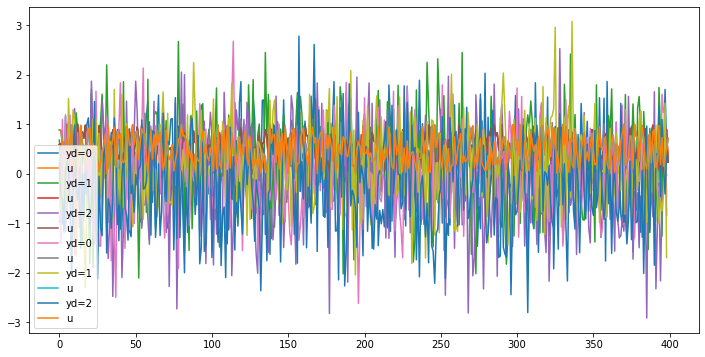

In [0]:
#Plot ys
plt.figure(figsize=(12, 6))
for i in range(0,num_obs):
  for j in range(0,yd):
    plt.plot(y[i,:,j,0], label = 'yd={}'.format(j)) 
    plt.plot(u[i,:,0,0], label='u')

plt.legend()

In [0]:
# seed = np.random.randint(low=0, high=1000000)
# #seed=579#53672#579#53672# 577#576#66934#126829#665346 #97865
# print('seed={}'.format(seed))
# npr.seed(seed)


# Estep_burn_iters=1
# Estep_sample_iters=1
# mstep_iters=100
# num_post_samples=20
# post_burn_iters = 10
# tanh_window=4 
# tanh_numparts=16 
# tanh_temp= 1
# i_window=4 
# i_numparts=8
# i_temp= 1
# r_window=4 
# r_numparts=8
# r_temp= 1

# rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
#             #so forget old suff stats more quickly, 
#             #which leads to quicker updates but more instability
# #NEED to fix where num_obs%mbsize != 0:
# warmup_iters = 0 #250
# num_obs=2
# mb_size=2


# d = 10
# yd = 3 #y dimension
# ud=yd #u' dimension
# T = 400
# T_train = 15
# mu_init = np.zeros((num_obs, d,1))

# ####inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)####
# #x0 = npr.uniform(-1,1,size=(num_obs,d,1))


# '''
# u_ = 0*np.ones((T, ud,1))#npr.uniform(size=(T,ud,1))
# #u_[0:T_train-5:5] = -1
# #u_[T_train+5:-1:8] = -1
# u = np.concatenate((u_, np.ones((T,1,1))), axis=1)
# '''
# sigma_init = npr.uniform(size=(d,1))#0.3*np.ones((d,1))
# sigma = npr.uniform(size=(d,1))#0.2*np.ones((d,1))
# sigma_true = 0.1*np.ones((d,1))
# sigma_y = npr.uniform(size=(yd,1))#0.1*np.ones((yd,1)) 
# sigma_ytrue = 0.1*np.ones((yd,1)) 

# Wbar_prior = 0*np.ones((d,d+ud+1))
# Wbar_sigma = .1*np.ones(Wbar_prior.shape)
# Wbari = npr.normal(Wbar_prior, Wbar_sigma)
# Wi = Wbari[:,:d]
# Bi = Wbari[:,d:]

# Wbarr = npr.normal(Wbar_prior, Wbar_sigma)
# Wr = Wbarr[:,:d]
# Br = Wbarr[:,d:]

# Wbarp = npr.normal(Wbar_prior, Wbar_sigma)
# Wp = Wbarp[:,:d]
# Bp = Wbarp[:,d:]


# Wbary_prior = 0*np.ones((yd,d+1))
# Wbary_sigma = .1*np.ones(Wbary_prior.shape)

# Wbary = npr.normal(Wbary_prior, Wbary_sigma)
# C = Wbary[:,:d]
# by = Wbary[:,d:]




# #sine wave
# #data = np.sin(.2*(np.arange(0,T,1))).reshape(T,1,1)
# u = np.zeros((num_obs, T, ud+1,1))
# y = np.zeros((num_obs, T-1,yd,1))
# data = np.zeros((num_obs,T,1,1))
# for i in range(num_obs):
#   c = npr.uniform(0.18,0.22)
#   data[i] = np.sin(c*(np.arange(0,T,1))).reshape(T,1,1)
#   y[i] = data[i,1:]+sigma_ytrue*npr.randn(*data[i,1:].shape)

#   u_ = 0*np.ones((T, ud,1))
#   u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)
#   u[i,1,:ud]=data[i,0]+sigma_ytrue*npr.randn(*data[i,0].shape)
#   u[i,2:,:ud] = y[i,:-1,:]


# # Sample the vanilla RNN
# x = np.zeros((num_obs,T, d, 1))
# for i in range(num_obs):
#   x[i,0] = mu_init[i]+sigma*npr.randn(d,1)

#   W_obs = Wi 
#   B_obs = Bi

#   for t in range(1, T):
#     x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) + sigma * npr.randn(d,1)

# zi = npr.randint(low=0, high=i_numparts,size=x[:,1:T_train].shape)
# zr = npr.randint(low=0, high=r_numparts,size=x[:,1:T_train].shape)
# zp = npr.randint(low=0, high=tanh_numparts,size=x[:,1:T_train].shape)


# x_obs = np.copy(x) 

seed=370234


In [0]:
def plot_y_preds(y, T,T_train,  ypred_mean, ypred_std, ytrue_mean, ytrue_std, ypred2_mean, ypred2_std, Wbar_prior, Wbar_sigma, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  plt.plot(np.arange(0,T),y[:,0,0], label='observed y')
  
  plt.plot(np.arange(0,T), ytrue_mean[0:],color='green', label='true y mean')
  plt.fill_between(np.arange(T), 
                  ytrue_mean - 2 * ytrue_std, 
                  ytrue_mean + 2 * ytrue_std,
                  color='green',
                  alpha=0.3)
  
  
  plt.plot(ypred_mean[:T_train], color='orange', label='gen y mean using W samples')
  plt.fill_between(np.arange(0,T_train), 
                  ypred_mean[:T_train] - 2 * ypred_std[:T_train], 
                  ypred_mean[:T_train] + 2 * ypred_std[:T_train],
                  color='orange',
                  alpha=0.5)
  
  plt.plot(np.arange(T_train-1,T), ypred2_mean, color='purple', label='post y pred')

  plt.fill_between(np.arange(T_train-1,T), 
                  ypred2_mean - 2 * ypred2_std, 
                  ypred2_mean + 2 * ypred2_std,
                  color='purple',
                  alpha=0.3)
  
  plt.title('Observation y predictions')
  plt.legend()

In [0]:
def plot_inf(x, T,T_train,  xsample_mean, xsample_std, sigma, d, num_parts, temp):
  plt.figure(figsize=(12, 8))
  #plt.plot(np.arange(0,T),x[0:], label='True latent state from observed sample')
  
  
  plt.plot(np.arange(0,T_train), xsample_mean[0:T_train], color='orange', label='Posterior latent mean')

  plt.fill_between(np.arange(0,T_train), 
                  xsample_mean[0:T_train] - 2 * xsample_std[0:T_train], 
                  xsample_mean[0:T_train] + 2 * xsample_std[0:T_train],
                  color='orange',
                  alpha=0.3)
  
  #plt.title('d={}, sigma={},\n num_parts={}, temp={}'.format(d, sigma,num_parts, temp  ))
  #plt.legend()

In [0]:
def plotx_pred(T,T_train,xpred_mean, xpred_std, xpostpred_mean, xpostpred_std, sigma, d, num_parts, temp):
  #plt.figure(figsize=(12, 8))
  
  #plt.plot(np.arange(0,T),xtrue_mean[0:],color='green', label='True latent mean')
  #plt.fill_between(np.arange(T), 
  #                xtrue_mean - 2 * xtrue_std, 
  #                xtrue_mean + 2 * xtrue_std,
  #                color='green',
  #                alpha=0.3)
  
  
  #plt.plot(xpred_mean, color='orange', label='gen x mean using W samples')
  #plt.fill_between(np.arange(T), 
  #                xpred_mean - 2 * xpred_std, 
  #                xpred_mean + 2 * xpred_std,
  #                color='orange',
  #                alpha=0.5)
  

  plt.plot(np.arange(T_train,T), xpostpred_mean, color='purple', label='Posterior latent prediction')

  plt.fill_between(np.arange(T_train,T), 
                  xpostpred_mean - 2 * xpostpred_std, 
                  xpostpred_mean + 2 * xpostpred_std,
                  color='purple',
                  alpha=0.3)
  
  plt.title('x latent state dynamics, dim={}'.format(d ))
  plt.legend()

# Run Gibbs sampler 

In [56]:
#seed = np.random.randint(low=0, high=1000000)
seed=579#53672#579#53672# 577#576#66934#126829#665346 #97865
print('seed={}'.format(seed))
npr.seed(seed)


Estep_burn_iters=1
Estep_sample_iters=1
mstep_iters=100
num_post_samples=20
post_burn_iters = 10
tanh_window=4 #4
tanh_numparts=16 #16
tanh_temp= .1#1#.25
rhoexp = .6 #0.5< rhoexp <=1 #smaller, leads to larger updates, 
            #so forget old suff stats more quickly, 
            #which leads to quicker updates but more instability
#NEED to fix where num_obs%mbsize != 0:
warmup_iters = 0 #250
num_obs=4
mb_size=2


d = 10
yd = 1 #y dimension
ud=yd #u' dimension
T = 400
T_train = 200
mu_init = np.zeros((num_obs, d,1))

####inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)####
#x0 = npr.uniform(-1,1,size=(num_obs,d,1))


'''
u_ = 0*np.ones((T, ud,1))#npr.uniform(size=(T,ud,1))
#u_[0:T_train-5:5] = -1
#u_[T_train+5:-1:8] = -1
u = np.concatenate((u_, np.ones((T,1,1))), axis=1)
'''
sigma_init = 0.01*np.ones((d,1))
sigma = 0.01*np.ones((d,1))
sigma_true = 0.01*np.ones((d,1))
sigma_y = 0.01*np.ones((yd,1)) 
sigma_ytrue = 0.01*np.ones((yd,1)) 

Wbar_prior = 0*np.ones((d,d+ud+1))
Wbar_sigma = .1*np.ones(Wbar_prior.shape)
Wbar = npr.normal(Wbar_prior, Wbar_sigma)
W = Wbar[:,:d]
B = Wbar[:,d:]


Wbary_prior = 0*np.ones((yd,d+1))
Wbary_sigma = .1*np.ones(Wbary_prior.shape)

Wbary = npr.normal(Wbary_prior, Wbary_sigma)
C = Wbary[:,:d]
by = Wbary[:,d:]




#sine wave
#data = np.sin(.2*(np.arange(0,T,1))).reshape(T,1,1)
u = np.zeros((num_obs, T, ud+1,1))
y = np.zeros((num_obs, T-1,yd,1))
data = np.zeros((num_obs,T,1,1))
for i in range(num_obs):
  c = npr.uniform(0.18,0.22)
  data[i] = np.sin(c*(np.arange(0,T,1))).reshape(T,1,1)
  y[i] = data[i,1:]+sigma_ytrue*npr.randn(*data[i,1:].shape)

  u_ = 0*np.ones((T, ud,1))
  u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)
  u[i,1,0]=data[i,0]+sigma_ytrue*npr.randn()
  u[i,2:,0] = y[i,:-1,:,0]


# Sample the vanilla RNN
x = np.zeros((num_obs,T, d, 1))
for i in range(num_obs):
  x[i,0] = mu_init[i]+sigma*npr.randn(d,1)

  W_obs = W 
  B_obs = B

  for t in range(1, T):
    x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) + sigma * npr.randn(d,1)

z = npr.randint(low=0, high=tanh_numparts,size=x[:,1:T_train].shape)

# #random vanilla RNN data
# lo1 = -.5
# hi1 = -.3

# lo2 = .3
# hi2= .5

# #lo1 = .8
# #hi1 = 1

# #lo2 = .2
# #hi2= .4

# Wbar = npr.normal(Wbar_prior, Wbar_sigma)
# W_true = npr.uniform(lo1,hi1,size=W.shape)
# B_true = npr.uniform(lo2,hi2,size=B.shape)


# C_true = npr.uniform(lo1,hi1,size=C.shape)
# by_true = npr.uniform(lo2,hi2,size=by.shape)

# x0 = npr.uniform(-.5,.5,size=(num_obs, d,1))
# u = np.zeros((num_obs, T, ud+1,1))
# y = np.zeros((num_obs, T-1,yd,1))
# x = np.zeros((num_obs,T, d, 1))
# for i in range(num_obs):
#   u_ = 0*np.ones((T, ud,1))
#   u[i] = np.concatenate((u_, np.ones((T,1,1))), axis=1)

# # Sample the vanilla RNN
#   x[i,0] = x0[i]
#   u[i,1,:ud] = npr.uniform(size=u[i,1,:ud].shape)
#   W_obs = W_true 
#   B_obs = B_true
#   for t in range(1, T):
#     x[i,t] = np.tanh(W_obs @ x[i,t-1] + B_obs @ u[i,t]) + sigma_true * npr.randn(d,1)
#     y[i,t-1] = C_true @ x[i,t]+by_true +sigma_ytrue*npr.randn(*y[i,t-1].shape)
#     if t != T-1:
#       u[i,t+1,:ud] = y[i,t-1]


x_obs = np.copy(x) 

seed=579


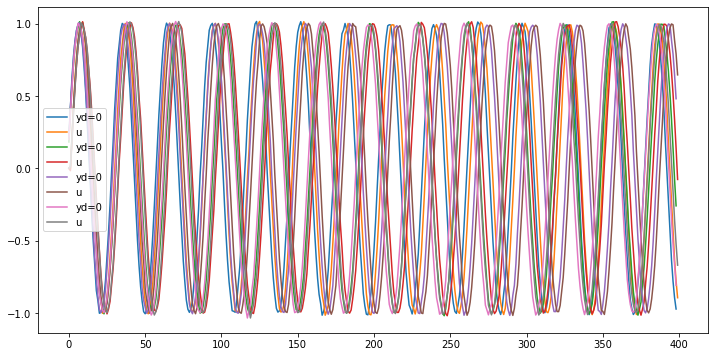

In [57]:
#Plot ys
plt.figure(figsize=(12, 6))
for i in range(0,num_obs):
  for j in range(0,yd):
    plt.plot(y[i,:,j,0], label = 'yd={}'.format(j)) 
    plt.plot(u[i,:,0,0], label='u')

plt.legend()

In [58]:
#Sine Wave
M=1000

y_true = np.zeros((num_obs,M,T-1,yd,1))

for j in range(0,num_obs):
  for n in range(M):
    y_true[j,n] = data[j,1:]+sigma_ytrue*npr.randn(*data[j,1:].shape)




ytrue_mean = np.mean(y_true, axis=1)[:,:,:,0]
ytrue_std = np.std(y_true, axis=1)[:,:, :,0]


print(ytrue_mean.shape)

(4, 399, 1)


In [0]:
# #Random data
# M=100

# x_true = np.zeros((num_obs,M,T,d,1))
# y_true = np.zeros((num_obs,M,T-1,yd,1))

# for i in range(num_obs):
#   for m in range(0,M):
#     # Sample the vanilla RNN
#     x_true[i,m,0] = x0[i]
#     ut = npr.uniform(size=u[i,1].shape)
#     W_obs = W_true 
#     B_obs = B_true


#     for t in range(1, T):
#       x_true[i,m,t] = np.tanh(W_obs @ x_true[i,m,t-1] + B_obs @ ut)
#       y_true[i,m,t-1] = C_true @ x_true[i,m,t]+by_true +sigma_ytrue*npr.randn(*y_true[i,m,t-1].shape)     
#       ut = np.concatenate((y_true[i,m,t-1], np.ones((1,1))), axis=0)
#     print(m)



# ytrue_mean = np.mean(y_true, axis=1)[:,:,:,0]
# ytrue_std = np.std(y_true, axis=1)[:,:, :,0]


# print(ytrue_mean.shape)

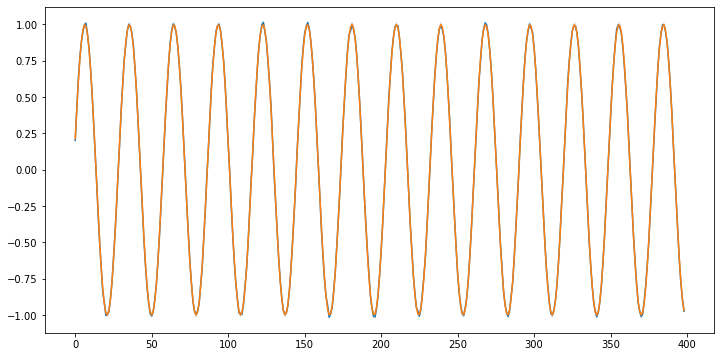

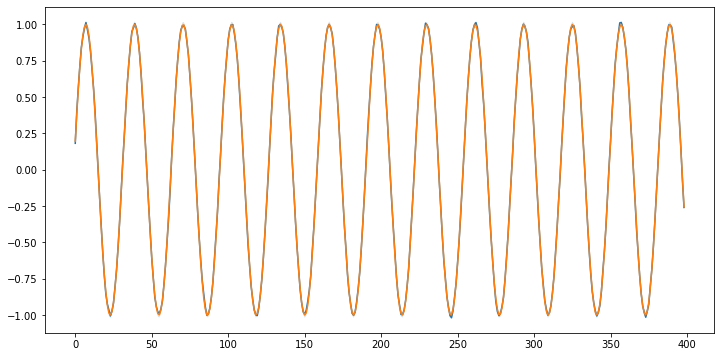

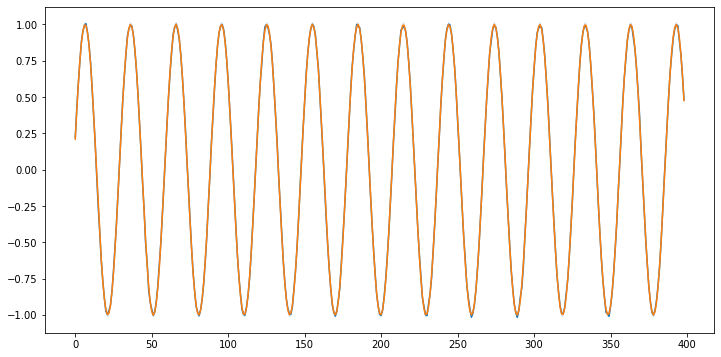

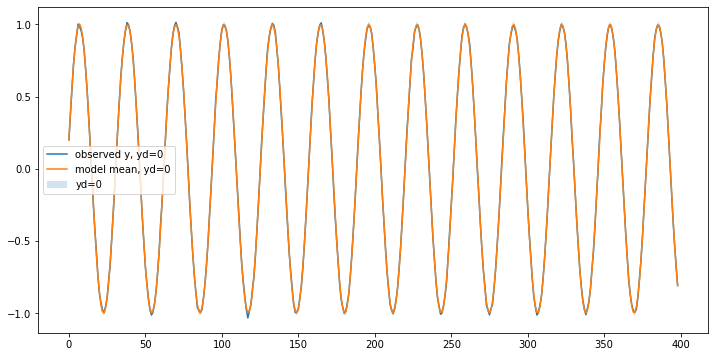

In [60]:
#Plot y means
for obs in range(num_obs):
  plt.figure(figsize=(12, 6))
  for i in range(0,yd):
    plt.plot(y[obs,:,i,0], label='observed y, yd={}'.format(i))
    plt.plot(ytrue_mean[obs,:,i], label='model mean, yd={}'.format(i))
    plt.fill_between(np.arange(T-1), 
                    ytrue_mean[obs,:,i] - 2 * ytrue_std[obs,:,i], 
                    ytrue_mean[obs,:,i] + 2 * ytrue_std[obs,:,i],
                    alpha=0.2, label='yd={}'.format(i))

plt.legend()

num_parts=16
0
-inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


1
-3357.9444480437814
2
7046.756010754523
3
13603.957380478601
4
12818.577194564834
5
13724.225190189416
6
11892.890029585322
7
13362.135327597323
8
12697.95877547978
9
14274.159994212081
10
11296.272811208333
11
14214.92707132031
12
11368.775551153187
13
13613.757873924538
14
10576.382405250251
15
12978.699460495389
16
10557.568684159061
17
13055.146609447327
18
10787.48021460541
19
13518.086035421587
20
9928.199175408077
21
13500.549883547585
22
9484.271727189955
23
13465.300422938677
24
10478.671949530088
25
13354.428284645388
26
11427.935410698046
27
13921.8579776316
28
15630.935497164934
29
12892.251041048632
30
14415.433268301644
31
11877.358806320331
32
13993.73538105237
33
12888.869462026836
34
13906.067190298663
35
12548.075751874563
36
11800.47527894393
37
13677.504717912821
38
12034.976203651286
39
13133.445860420237
40
10748.204915059217
41
11170.079214842932
42
9621.25164015753
43
12146.324446209055
44
11215.626530440317
45
12633.996354433715
46
11357.116840427017
47
13745

Text(0.5, 0, 'iterations')

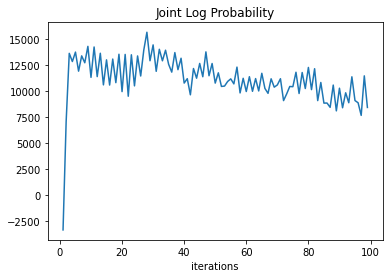

In [61]:
spwl_vanRNN = StochPiecewiseLinearVanillaRNN(W,B,mu_init,sigma_init,sigma, C,by,sigma_y,tanh_num_parts=tanh_numparts, tanh_window=tanh_window,  tanh_temp=tanh_temp)
batch_ops=Batch_Ops_vanRNN(y[:,:T_train-1], x[:,:T_train], u[:,:T_train], z, rhoexp)


#Warmup period to build up state:
######May need to add

mb_ind = 0
log_like_theta = []
#Burn-in period

for i in range(mstep_iters):
  ss_array = 0
  if mb_size < num_obs:
    batch_ops.update_rho(spwl_vanRNN,i)
  if mb_ind*mb_size >= num_obs:
    mb_ind = 0
  batch_ops.get_batch(spwl_vanRNN,mb_size, mb_ind)
  #log_like_batch = []
  for j in range(Estep_burn_iters):
    spwl_vanRNN.gibbs_Estep()
    #batch_ops.store_batch(spwl_vanRNN,mb_size, mb_ind)
    #log_like_batch.append(spwl_vanRNN.log_joint_nopgs(batch_ops))
    #print(log_like_batch[j])
  #if i ==5:
    #plt.plot(log_like_batch)
    #sys.exit()
  for j in range(Estep_sample_iters):
    ss_array += spwl_vanRNN.gibbs_Estep()


  batch_ops.store_batch(spwl_vanRNN,mb_size, mb_ind)
  ss_array = ss_array/Estep_sample_iters
  spwl_vanRNN.Mstep(ss_array)
  mb_ind += 1
  #log_like_theta.append(spwl_vanRNN.log_joint_nopgs(batch_ops)) 
  log_like_theta.append(spwl_vanRNN.log_joint_nopgs(batch_ops.x_full, 
                                                    batch_ops.y_full,
                                                    batch_ops.u_full,
                                                    batch_ops.z_full))
  print(i)
  print(log_like_theta[i])

#Collect samples
#mb_size=num_obs
x_samples = np.zeros((num_post_samples,num_obs,T_train,d,1))

mb_ind =0 
for m in range(0,int(num_obs/mb_size)):
  #log_like_batch = []
  batch_ops.get_batch(spwl_vanRNN,mb_size, mb_ind)

  #Burn in 
  for i in range(post_burn_iters):    
    spwl_vanRNN.gibbs_Estep()
    print(i)
    #batch_ops.store_batch(spwl_vanRNN,mb_size, mb_ind)
    #log_like_batch.append(spwl_vanRNN.log_joint_nopgs(batch_ops))
    #print(log_like_batch[i])

  #plt.plot(log_like_batch) 
  #sys.exit() 

  #Collect Samples
  for i in range(num_post_samples):   
    spwl_vanRNN.gibbs_Estep()
    x_samples[i,mb_ind*mb_size:mb_ind*mb_size+mb_size] = spwl_vanRNN.x
    print(i)
  mb_ind += 1
  print(m)

plt.title('Joint Log Probability')
plt.plot(log_like_theta)
plt.xlabel('iterations')

In [0]:
#Make Predictions
xpreds = np.zeros((num_post_samples,num_obs, T, d, 1))
ypreds = np.zeros((num_post_samples, num_obs,T-1, yd, 1))
ypreds2 = np.zeros((num_post_samples,num_obs, T_train-1, yd, 1))


xpreds_test = np.zeros((num_post_samples,num_obs, T, d, 1))
ypreds_test = np.zeros((num_post_samples,num_obs, T-T_train, yd, 1))


for n in range(num_post_samples):
  xpreds[n,:,0] = mu_init + sigma_init*npr.randn(*mu_init.shape)


  W = spwl_vanRNN.spwl_tanh.W
  B = spwl_vanRNN.spwl_tanh.B

  C = spwl_vanRNN.obs.C
  by = spwl_vanRNN.obs.by

  for t in range(1,T):
    #Using Sampled Weights
    mu_pred,_ = spwl_vanRNN.spwl_tanh.f(W @ xpreds[n,:, t-1] + B @ u[:,t],return_z=True)

    xpreds[n,:, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)

  muy = C @ xpreds[n,:,1:]+by
  ypreds[n] = muy + sigma_y*npr.randn(*muy.shape)
  muy = C @ x_samples[n,:,1:]+ by
  ypreds2[n] = muy + sigma_y*npr.randn(*muy.shape)


  xpreds_test[n,:, T_train-1]=x_samples[n,:,-1] 
  ut = u[:,T_train]
  for t in range(T_train,T):
    mu_pred,_ = spwl_vanRNN.spwl_tanh.f(W @ xpreds_test[n,:,t-1] + B @ ut,return_z=True)
    xpreds_test[n,:,t] = mu_pred + sigma * npr.randn(*mu_pred.shape)
    muy = C @ xpreds_test[n,:,t]+by
    ypreds_test[n,:,t-T_train] = muy+sigma_y*npr.randn(*muy.shape)
    ut = np.concatenate((ypreds_test[n,:,t-T_train], np.ones(ypreds_test[n,:,t-T_train].shape)),axis=1)



xpreds_mean = np.mean(xpreds, axis=0)[:,:,:,0]
xpreds_std = np.std(xpreds, axis=0)[:, :,:,0]


xpostpreds_mean = np.mean(xpreds_test[:,:,T_train:], axis=0)[:,:,:,0]
xpostpreds_std = np.std(xpreds_test[:,:,T_train:], axis=0)[:, :,:,0]


ypreds_mean = np.mean(ypreds, axis=0)[:,:,:,0]
ypreds_std = np.std(ypreds, axis=0)[:,:,:,0]

ypreds2_mean = np.mean(ypreds2, axis=0)[:,:,:,0]
ypreds2_std = np.std(ypreds2, axis=0)[:, :,:,0]

ypreds_test_mean = np.mean(ypreds_test, axis=0)[:,:,:,0]
ypreds_test_std = np.std(ypreds_test, axis=0)[:, :,:,0]

In [0]:
#Inference results
for m in range(0,num_obs):
  print('obs={}'.format(m))
  for i in range(0,d):
    xsample_mean = np.mean(x_samples, axis=0)[m,:,i,0]
    xsample_std = np.std(x_samples,axis=0)[m,:,i,0]


    plot_inf(x_obs[m,:,i,0], T,T_train,  xsample_mean, xsample_std, sigma, d, tanh_numparts, tanh_temp)
    plotx_pred(T,T_train,xpreds_mean[m,:,i], xpreds_std[m,:,i], xpostpreds_mean[m,:,i], xpostpreds_std[m,:,i], sigma, d, tanh_numparts, tanh_temp)

Output hidden; open in https://colab.research.google.com to view.

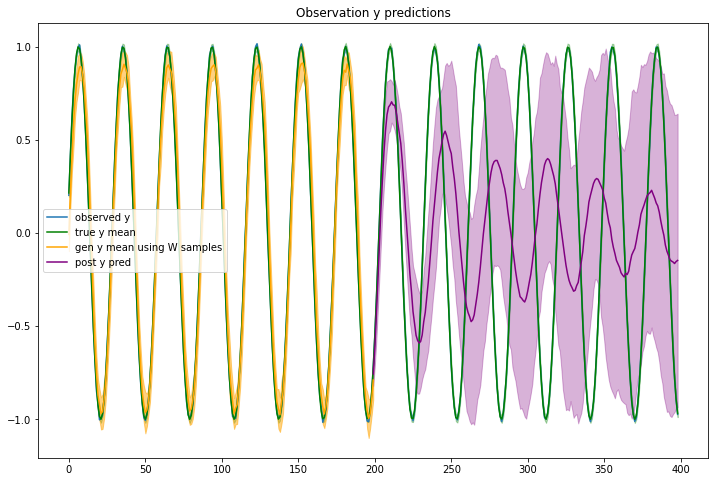

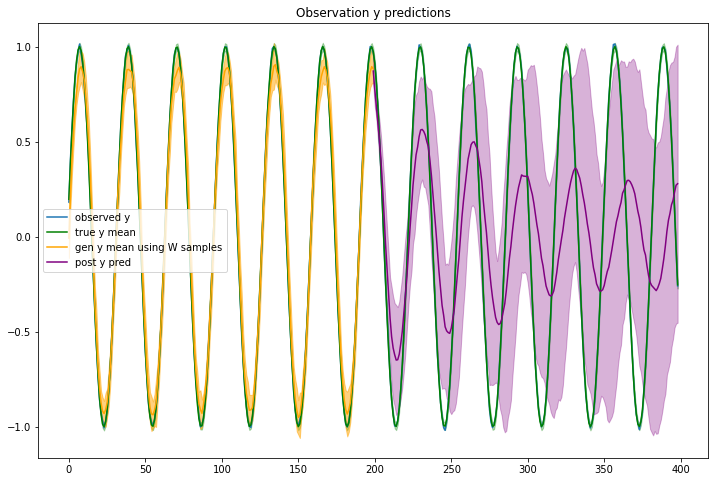

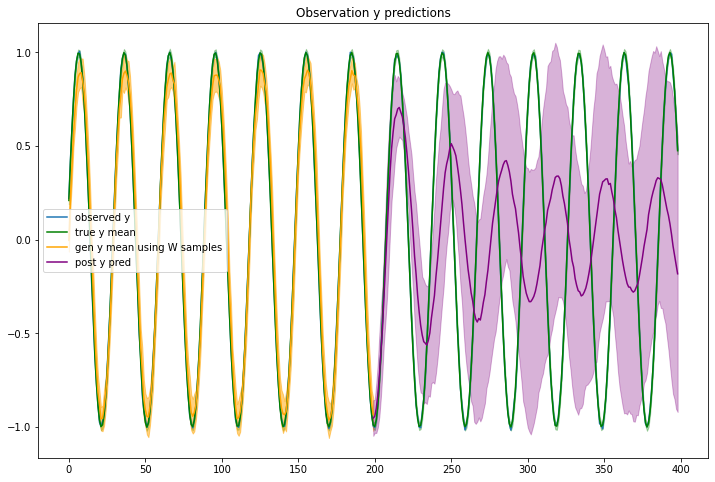

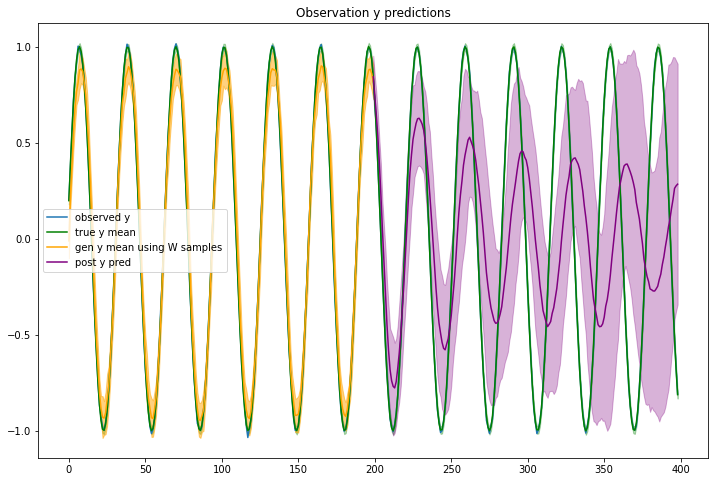

In [49]:
#prediction results
for m in range(0,num_obs):
  for i in range(0,yd):
    plot_y_preds(y[m],T-1,T_train, ypreds_mean[m,:,i], ypreds_std[m,:,i], ytrue_mean[m,:,i], ytrue_std[m,:,i],ypreds_test_mean[m,:,i], ypreds_test_std[m,:,i],Wbar_prior, Wbar_sigma, sigma, mstep_iters, tanh_numparts, tanh_temp)
    #plt.plot(ypreds2_mean[:,i][:T_train], color='black', label='gen y mean using W samples')
    #plt.fill_between(np.arange(0,T_train-1), 
    #                ypreds2_mean[:,i][:T_train] - 2 * ypreds2_std[:,i][:T_train], 
    #                ypreds2_mean[:,i][:T_train] + 2 * ypreds2_std[:,i][:T_train],
    #                color='black',
    #                alpha=0.5)

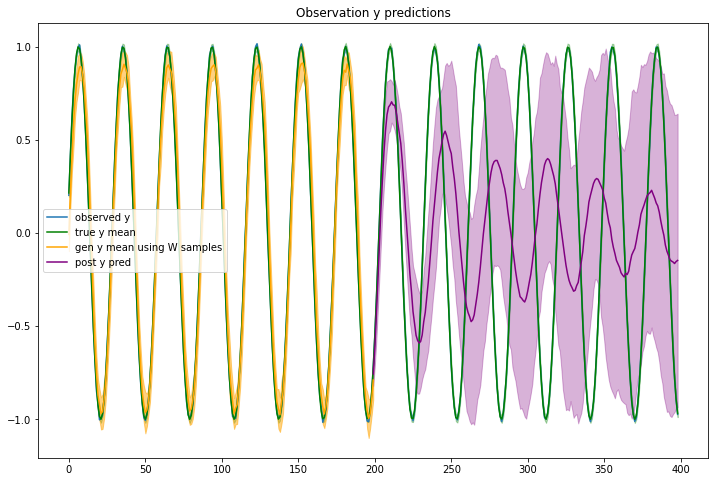

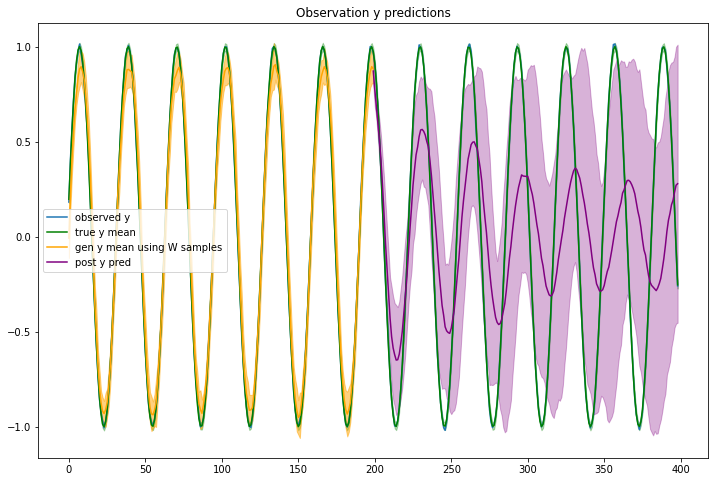

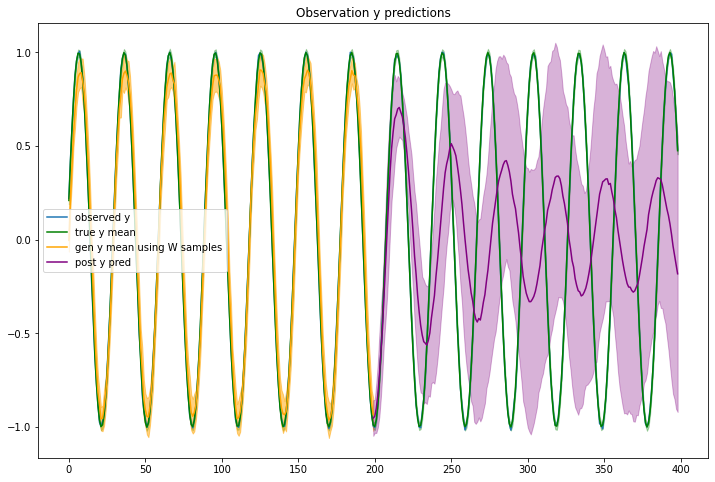

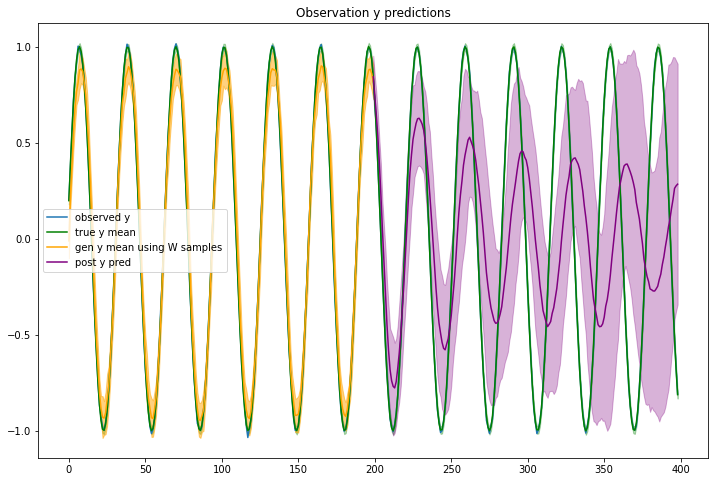

In [0]:
#prediction results
for m in range(0,num_obs):
  for i in range(0,yd):
    plot_y_preds(y[m],T-1,T_train, ypreds_mean[m,:,i], ypreds_std[m,:,i], ytrue_mean[m,:,i], ytrue_std[m,:,i],ypreds_test_mean[m,:,i], ypreds_test_std[m,:,i],Wbar_prior, Wbar_sigma, sigma, mstep_iters, tanh_numparts, tanh_temp)
    #plt.plot(ypreds2_mean[:,i][:T_train], color='black', label='gen y mean using W samples')
    #plt.fill_between(np.arange(0,T_train-1), 
    #                ypreds2_mean[:,i][:T_train] - 2 * ypreds2_std[:,i][:T_train], 
    #                ypreds2_mean[:,i][:T_train] + 2 * ypreds2_std[:,i][:T_train],
    #                color='black',
    #                alpha=0.5)

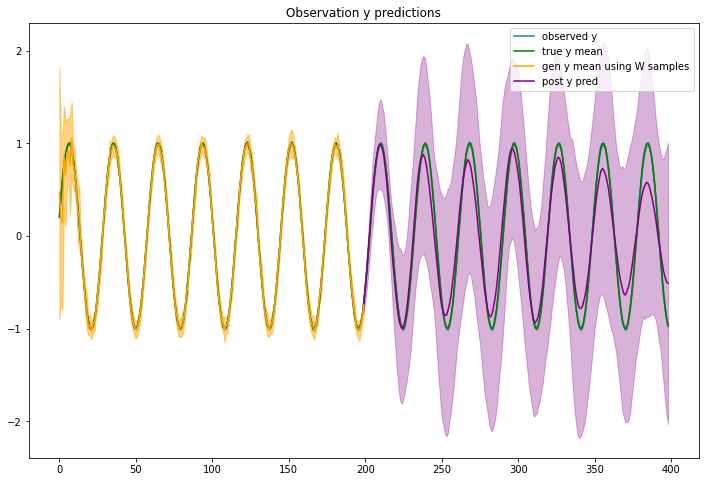

In [0]:
#prediction results
for m in range(0,num_obs):
  for i in range(0,yd):
    plot_y_preds(y[m],T-1,T_train, ypreds_mean[m,:,i], ypreds_std[m,:,i], ytrue_mean[m,:,i], ytrue_std[m,:,i],ypreds_test_mean[m,:,i], ypreds_test_std[m,:,i],Wbar_prior, Wbar_sigma, sigma, mstep_iters, tanh_numparts, tanh_temp)
    #plt.plot(ypreds2_mean[:,i][:T_train], color='black', label='gen y mean using W samples')
    #plt.fill_between(np.arange(0,T_train-1), 
    #                ypreds2_mean[:,i][:T_train] - 2 * ypreds2_std[:,i][:T_train], 
    #                ypreds2_mean[:,i][:T_train] + 2 * ypreds2_std[:,i][:T_train],
    #                color='black',
    #                alpha=0.5)

In [0]:
# class StochPiecewiseLinearGRU(object):
#     def __init__(self,Wi, Bi,Wr,Br, Wp, Bp, mu_init, sigma_init, sigma_x, C, by, sigma_y,sigma_i, sigma_r, tanh_numparts=16,
#                  tanh_window=4, tanh_temp=0.25,sigmoid_i_numparts=16,
#                  sigmoid_i_window=4, sigmoid_i_temp=0.25,sigmoid_r_numparts=16,
#                  sigmoid_r_window=4, sigmoid_r_temp=0.25):
#       self.sigmoid_i=StochPiecewiseLinearSigmoid(Wi,Bi,sigma_i**2,sigmoid_i_numparts,sigmoid_i_window,sigmoid_i_temp)
#       self.sigmoid_r=StochPiecewiseLinearSigmoid(Wr,Br,sigma_r**2,sigmoid_r_numparts,sigmoid_r_window,sigmoid_r_temp)
#       self.tanh=StochPiecewiseLinearTanh(Wp,Bp,tanh_numparts,tanh_window,tanh_temp)
#       self.obs = LinearObsModel(C, by,sigma_y**2)

#       self.mu_init=mu_init
#       self.sigmasq_init=sigma_init**2 
#       self.sigmasq=sigma_x**2
#       self.x = None
#       self.u = None
#       self.y = None
#       self.rho = 1
#       self.suff_stats_vec=0

#     def x_mean(self, i, inx_p, zp, xmin):
#       return i*(self.tanh.f_given_z(inx_p, zp)-xmin)+xmin

#     def suff_stats(self):
#       pass

#     def zi_update(self,inx_i):
#       yhat = self.sigmoid_i.f_given_z(inx_i,np.arange(self.sigmoid_i.num_parts))
#       log_lkhd = -0.5 * (self.sigmoid_i.output - yhat)**2 / self.sigmoid_i.sigmasq_out
#       self.sigmoid_i.z,self.sigmoid_i.ms,self.sigmoid_i.Vs=self.sigmoid_i.resample(inx_i,log_lkhd)

#     def zr_update(self, inx_i, inx_r, iny):
#       self.sigmoid_r.ms = np.zeros(self.sigmoid_r.z.shape)
#       self.sigmoid_r.Vs = np.zeros(self.sigmoid_r.z.shape)
#       i=self.sigmoid_i.f_given_z(inx_i,self.sigmoid_i.z)
#       zr_shape=self.sigmoid_r.z.shape
#       zj = np.zeros((zr_shape[0],zr_shape[1],zr_shape[2],self.sigmoid_r.num_parts),dtype=int)
#       zp_lkhd = np.zeros(zj.shape)
#       zp_rav = self.tanh.z.ravel()

#       for j in range(self.sigmoid_r.z.shape[2]):
#         zj[:,:,np.arange(zr_shape[2])!=j] = self.sigmoid_r.z[:,:,np.arange(zr_shape[2])!=j] 
#         zj[:,:,j] = np.arange(self.sigmoid_r.num_parts)
#         r = self.sigmoid_r.f_given_z(inx_r, zj)
#         inx_p = self.tanh.get_inx(r*self.x[:,:-1], self.u[:,1:])
#         yhat = self.x_mean(i, inx_p, self.tanh.z,self.x[:,:-1])

#         for k in range(self.sigmoid_r.num_parts):
#           zpk = self.tanh.discrete_prior(2*inx_p[...,k][...,None])
#           zpk = zpk.reshape(-1,zpk.shape[3])      
#           zpk_lkhd = zpk[np.arange(len(zp_rav)),zp_rav]
#           zp_lkhd[...,k] = zpk_lkhd.reshape(zp_lkhd.shape[:3])
        
#         zp_loglkhd = np.sum(np.log(zp_lkhd),axis=2,keepdims=True)
#         x_log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
#         x_log_lkhd = np.sum(x_log_lkhd, axis=2,keepdims=True)
#         log_lkhd = zp_loglkhd + x_log_lkhd
#         zs,ms,Vs=self.sigmoid_r.resample(inx_r[:,:,j,None],log_lkhd)
#         self.sigmoid_r.z[:,:,j]=zs[:,:,0,:]
#         self.sigmoid_r.ms[:,:,j]=ms[:,:,0,:]
#         self.sigmoid_r.Vs[:,:,j]=Vs[:,:,0,:]

#     def zp_update(self,inx_i,inx_r, iny):
#       i=self.sigmoid_i.f_given_z(inx_i,self.sigmoid_i.z)
#       r = self.sigmoid_r.f_given_z(inx_r, self.sigmoid_r.z)
#       inx_p = self.tanh.get_inx(r*self.x[:,:-1], self.u[:,1:])
#       yhat = self.x_mean(i, inx_p, np.arange(self.tanh.num_parts),self.x[:,:-1])
#       log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
#       self.tanh.z,self.tanh.ms,self.tanh.Vs=self.tanh.resample(inx_p,log_lkhd)

#     def x_pg_params(self, gate):      
#       J = gate.W.T @ ( gate.W*1/gate.Vs )
#       h = ((gate.W*1/gate.Vs).transpose((0,1,3,2)) @ (gate.ms- gate.B @ self.u[:,1:]))[:,:,:,0]
#       return J, h

#     def gibbs_Estep(self):
#       # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
#       inx_i = self.sigmoid_i.get_inx(self.x[:,:-1], self.u[:,1:])
#       inx_r = self.sigmoid_r.get_inx(self.x[:,:-1], self.u[:,1:])
#       iny = self.x[:,1:]

#       ###Sample zi discrete states and auxiliary variables:
#       self.zi_update(inx_i)

#       ###Sample zr discrete states and auxiliary variables:
#         #have to calculate per dimension, since there are cross terms 
#         #due to r \odot x_{t-1} term in zp distrbution
#       self.zr_update(inx_r)

#       ###Sample zp (for tanh) discrete states and auxiliary variables:
#       self.zp_update(inx_i,inx_r, iny)

#       # 2. Sample continuous states x given (linear Gaussian) observations y and 
#       #    current discrete states and auxiliary variables 

#       ###first Convert mean and variance on Wx + Bu to natural parameters on x
#       J_pg_i, h_pg_i = self.x_pg_params(self.sigmoid_i)  
#       J_pg_r, h_pg_r = self.x_pg_params(self.sigmoid_r)    
      
#       ####Convert mean and variance on W_p[r\odotx]+Bpu to natural parameters on x
#       J_pg_p, h_pg_p = self.x_pg_params(self.tanh)


#       #Get recurrence natural parameters for x 



#       # J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.spwl_tanh.x_recurrence_params(self.spwl_tanh.z, self.spwl_tanh.W, self.spwl_tanh.B,
#       #                                                                                                   self.u[:,1:],self.sigmasq,self.mu_init, self.sigmasq_init)


 


#     def test_gibbs_Estep(self):
#       # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
#       inx_i = self.sigmoid_i.get_inx(self.x[:,:-1], self.u[:,1:])
#       inx_r = self.sigmoid_r.get_inx(self.x[:,:-1], self.u[:,1:])
#       iny = self.x[:,1:]

#       #Test zi updates
#       self.zi_update(inx_i,inx_r, iny)
#       log_cond1 = cond_z(self.sigmoid_i)
#       log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,self.sigmoid_r.z,self.tanh.z)

#       self.zi_update(inx_i,inx_r, iny)
#       log_cond2 = cond_z(self.sigmoid_i)
#       log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,self.sigmoid_r.z,self.tanh.z)

#       print('zi')
#       check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
#       if check == True:
#         print(check)
#       else:
#         print(check)
#         print('log_joint1-log_joint2')
#         print(log_joint1-log_joint2)
#         print('log_cond1-log_cond2')
#         print(log_cond1-log_cond2)
      
#       #Test zr updates (need to fix)
#       for j in range(self.sigmoid_r.z.shape[2]):
#         log_cond1 = self.test_zr_update(inx_i, inx_r, iny,j)
#         log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,self.sigmoid_r.z,self.tanh.z)

#         log_cond2 = self.test_zr_update(inx_i, inx_r, iny,j)
#         log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,self.sigmoid_r.z,self.tanh.z)

#         print('zr_{}'.format(j))
#         check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
#         if check == True:
#           print(check)
#         else:
#           print(check)
#           print('log_joint1-log_joint2')
#           print(log_joint1-log_joint2)
#           print('log_cond1-log_cond2')
#           print(log_cond1-log_cond2)


#       #Test zp_update
#       self.zp_update(inx_i,inx_r, iny)
#       log_cond1 = cond_z(self.tanh)
#       log_joint1 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,self.sigmoid_r.z,self.tanh.z)

#       self.zp_update(inx_i,inx_r, iny)
#       log_cond2 = cond_z(self.tanh)
#       log_joint2 = self.log_joint_nopgs(self.x,self.y,self.u,self.sigmoid_i.z,self.sigmoid_r.z,self.tanh.z)

#       print('zp')
#       check = np.isclose(log_joint1-log_joint2,log_cond1-log_cond2,rtol=1e-10,atol=1e-10)
#       if check == True:
#         print(check)
#       else:
#         print(check)
#         print('log_joint1-log_joint2')
#         print(log_joint1-log_joint2)
#         print('log_cond1-log_cond2')
#         print(log_cond1-log_cond2)
#       sys.exit()
      

#     def test_zr_update(self, inx_i, inx_r, iny,j):     
#       self.sigmoid_r.ms = np.zeros(self.sigmoid_r.z.shape)
#       self.sigmoid_r.Vs = np.zeros(self.sigmoid_r.z.shape)
#       i=self.sigmoid_i.f_given_z(inx_i,self.sigmoid_i.z)
#       zr_shape=self.sigmoid_r.z.shape
#       zj = np.zeros((zr_shape[0],zr_shape[1],zr_shape[2],self.sigmoid_r.num_parts),dtype=int)
#       zp_lkhd = np.zeros(zj.shape)
#       zp_rav = self.tanh.z.ravel()

      
#       zj[:,:,np.arange(zr_shape[2])!=j] = self.sigmoid_r.z[:,:,np.arange(zr_shape[2])!=j] 
#       zj[:,:,j] = np.arange(self.sigmoid_r.num_parts)
#       r = self.sigmoid_r.f_given_z(inx_r, zj)
#       inx_p = self.tanh.get_inx(r*self.x[:,:-1], self.u[:,1:])
#       yhat = self.x_mean(i, inx_p, self.tanh.z,self.x[:,:-1])

#       for k in range(self.sigmoid_r.num_parts):
#         zpk = self.tanh.discrete_prior(2*inx_p[...,k][...,None])
#         zpk = zpk.reshape(-1,zpk.shape[3])      
#         zpk_lkhd = zpk[np.arange(len(zp_rav)),zp_rav]
#         zp_lkhd[...,k] = zpk_lkhd.reshape(zp_lkhd.shape[:3])
      
#       zp_loglkhd = np.sum(np.log(zp_lkhd),axis=2,keepdims=True)
#       x_log_lkhd = -0.5 * (iny - yhat)**2 / self.sigmasq
#       x_log_lkhd = np.sum(x_log_lkhd, axis=2,keepdims=True)
#       log_lkhd = zp_loglkhd + x_log_lkhd
#       zs,ms,Vs=self.sigmoid_r.resample(inx_r[:,:,j,None],log_lkhd)
#       self.sigmoid_r.z[:,:,j]=zs[:,:,0,:]
#       self.sigmoid_r.ms[:,:,j]=ms[:,:,0,:]
#       self.sigmoid_r.Vs[:,:,j]=Vs[:,:,0,:]

#       zr = self.sigmoid_r.z[:,:,j].reshape(-1, 1).ravel()
#       condz = self.sigmoid_r.cond_z.reshape(-1,self.sigmoid_r.cond_z.shape[3])
#       return np.sum(np.log(condz[np.arange(len(zr)),zr]))

    

#     def Mstep(self,ss_array):
#       pass


#     def log_joint_base(self, x,y,u,zi,zr,zp):
#       log_like = np.sum(cont_log_prior(x[:,0], self.mu_init, np.sqrt(self.sigmasq_init)))
      
#       inx_i = self.sigmoid_i.get_inx(x[:,:-1], u[:,1:])
#       i=self.sigmoid_i.f_given_z(inx_i,zi)
#       inx_r = self.sigmoid_r.get_inx(x[:,:-1], u[:,1:])
#       r = self.sigmoid_r.f_given_z(inx_r, zr)
#       inx_p = self.tanh.get_inx(r*x[:,:-1], u[:,1:]) 
#       mux = self.x_mean(i, inx_p, zp, x[:,:-1])

#       log_like +=   np.sum(cont_log_prior(x[:,1:], mux, np.sqrt(self.sigmasq)))    
#       muy = self.obs.C @ x[:,1:]+self.obs.by
#       log_like += np.sum(cont_log_prior(y, muy, np.sqrt(self.obs.sigmasq)))
#       return log_like, inx_i, inx_r, inx_p

#     def log_joint_nopgs(self, x,y,u,zi,zr,zp):
#       log_like, inx_i, inx_r, inx_p = self.log_joint_base(x,y,u,zi,zr,zp)
#       log_like += z_log_prior(zi, self.sigmoid_i, inx_i)
#       log_like += z_log_prior(zr, self.sigmoid_r, inx_r)
#       log_like += z_log_prior(zp, self.tanh, 2*inx_p)
#       return log_like